In [1]:
import os
import sys
sys.path.append('../common')
import shutil
import pandas as pd
import numpy as np
import keras
import keras.backend as K
from matplotlib import pyplot as plt
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser
from cyclic_lr import CyclicLR
from sklearn.model_selection import train_test_split



/home/niz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/niz/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


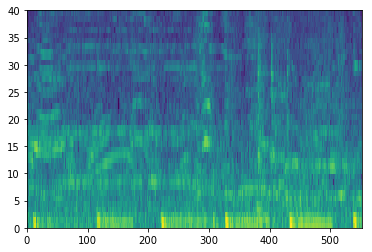

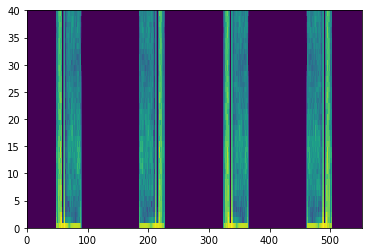

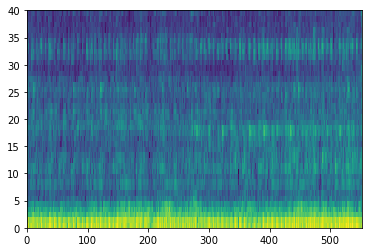

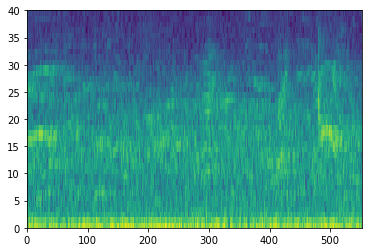

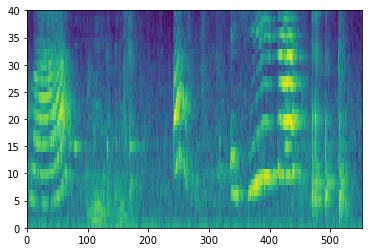

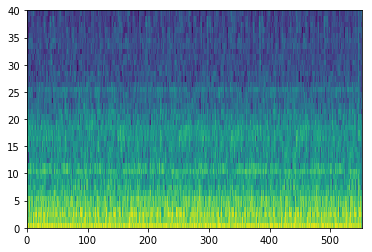

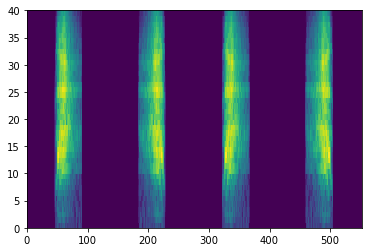

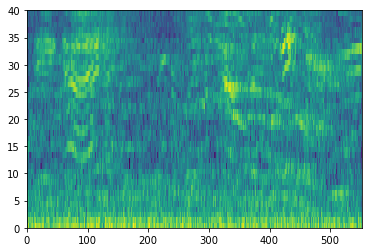

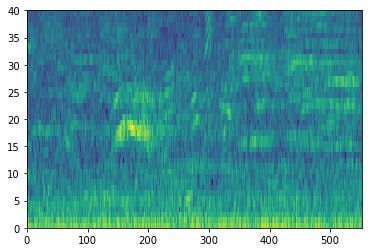

In [2]:
import os
import sys
sys.path.append('../common')
import shutil
import pandas as pd
import numpy as np
import keras
import keras.backend as K
from matplotlib import pyplot as plt
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser
from cyclic_lr import CyclicLR
from sklearn.model_selection import train_test_split

TRY = 'T4leak'
RANDOM_STATE = 42

# Mix train and valid, this makes training dataset leaked to validation dataset.
X_train_org = np.r_[np.load('X_train.npy'), np.load('X_valid.npy')]
y_train_org = keras.utils.to_categorical(np.r_[np.load('y_train.npy'), np.load('y_valid.npy')])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_org, y_train_org, test_size=0.1, random_state=RANDOM_STATE)

X_test = np.load('X_test.npy')
y_test = keras.utils.to_categorical(np.load('y_test.npy'))

# Make label lists
labels = ['air_conditioner',  'car_horn', 'children_playing', 'dog_bark', 'drilling',
    'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
label2int = {l:i for i, l in enumerate(labels)}
int2label = {i:l for i, l in enumerate(labels)}

# Normalize dataset
value_max = np.max(np.vstack([X_train, X_valid, X_test]))
X_train = X_train / value_max
X_valid = X_valid / value_max
X_test = X_test / value_max

# [:, 40, 552] -> [:, 40, 552, 1]
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Confirmation
def plot_dataset(X, n=3):
    for i in range(n):
        x = X[i]
        plt.pcolormesh(x[..., -1])
        plt.show()
for X in [X_train, X_valid, X_test]:
    plot_dataset(X)

In [3]:
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation, Dropout, BatchNormalization, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, TensorBoard

def model_cnn_alexnet(input_shape): # AlexNet based
    model = Sequential()
 
    model.add(Conv2D(48, 11,  input_shape=input_shape, strides=(2,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=(1,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, 5, strides=(2,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=2))
    model.add(BatchNormalization())

    model.add(Conv2D(192, 3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(192, 3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(128, 3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=(1,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [4]:
batch_size = 32 
num_classes = len(labels)
epochs = 150

callbacks = [
    CyclicLR(base_lr=0.00007, max_lr=0.0007, step_size=X_train.shape[0] // batch_size, mode='triangular'),
    ModelCheckpoint('model%s4.h5' % TRY,
                monitor='val_acc',
                verbose=1,
                save_best_only=True,
                save_weights_only=True),
     keras.callbacks.TensorBoard(log_dir='./%slog' % TRY, histogram_freq=0, write_graph=True, write_images=True)
]

datagen = ImageDataGenerator(
    #featurewise_center=True,  # set input mean to 0 over the dataset
    #featurewise_std_normalization=True,  # divide inputs by std of the dataset
    #rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    #width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
    #height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    #horizontal_flip=True,  # randomly flip images
    #preprocessing_function=get_random_eraser(v_l=np.min(X_train), v_h=np.max(X_train)) # RANDOM ERASER
)
#mixupgen = MixupGenerator(X_train, y_train, alpha=1.0, batch_size=batch_size, datagen=datagen)
test_datagen = ImageDataGenerator(
    #featurewise_center=True,  # set input mean to 0 over the dataset
    #featurewise_std_normalization=True,  # divide inputs by std of the dataset
)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(np.r_[X_train, X_valid, X_test])
#test_datagen.mean, test_datagen.std = datagen.mean, datagen.std

In [5]:
model = model_cnn_alexnet(X_train.shape[1:])
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 184, 48)       5856      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 91, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 91, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 31, 128)        153728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 15, 128)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 15, 128)        512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 15, 192)        221376    
__________

In [6]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=test_datagen.flow(X_valid, y_valid), callbacks=callbacks)

Epoch 1/150
192/195 [============================>.] - ETA: 0s - loss: 2.2430 - acc: 0.2640
Epoch 00001: val_acc improved from -inf to 0.30029, saving model to weightsT4leak4valid
195/195 [==============================] - 4s 19ms/step - loss: 2.2344 - acc: 0.2663 - val_loss: 2.4365 - val_acc: 0.3003
Epoch 2/150
193/195 [============================>.] - ETA: 0s - loss: 1.5549 - acc: 0.4721
Epoch 00002: val_acc improved from 0.30029 to 0.49425, saving model to weightsT4leak4valid
195/195 [==============================] - 3s 16ms/step - loss: 1.5526 - acc: 0.4726 - val_loss: 1.3794 - val_acc: 0.4943
Epoch 3/150
194/195 [============================>.] - ETA: 0s - loss: 1.3296 - acc: 0.5555
Epoch 00003: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 1.3321 - acc: 0.5552 - val_loss: 2.5604 - val_acc: 0.2730
Epoch 4/150
192/195 [============================>.] - ETA: 0s - loss: 1.2745 - acc: 0.5777
Epoch 00004: val_acc improved from 0.49425 to 0.60

Epoch 32/150
192/195 [============================>.] - ETA: 0s - loss: 0.1949 - acc: 0.9375
Epoch 00032: val_acc improved from 0.90661 to 0.91236, saving model to weightsT4leak4valid
195/195 [==============================] - 3s 16ms/step - loss: 0.1938 - acc: 0.9377 - val_loss: 0.3057 - val_acc: 0.9124
Epoch 33/150
194/195 [============================>.] - ETA: 0s - loss: 0.1836 - acc: 0.9444
Epoch 00033: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.1840 - acc: 0.9442 - val_loss: 1.0045 - val_acc: 0.6897
Epoch 34/150
193/195 [============================>.] - ETA: 0s - loss: 0.2121 - acc: 0.9321
Epoch 00034: val_acc improved from 0.91236 to 0.92241, saving model to weightsT4leak4valid
195/195 [==============================] - 3s 16ms/step - loss: 0.2109 - acc: 0.9327 - val_loss: 0.3004 - val_acc: 0.9224
Epoch 35/150
192/195 [============================>.] - ETA: 0s - loss: 0.1625 - acc: 0.9495
Epoch 00035: val_acc did not improve
195/19

191/195 [============================>.] - ETA: 0s - loss: 0.0732 - acc: 0.9799
Epoch 00096: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0718 - acc: 0.9803 - val_loss: 0.4095 - val_acc: 0.9210
Epoch 97/150
192/195 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9896
Epoch 00097: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0335 - acc: 0.9893 - val_loss: 0.9051 - val_acc: 0.8147
Epoch 98/150
193/195 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9867
Epoch 00098: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0470 - acc: 0.9865 - val_loss: 0.3642 - val_acc: 0.9224
Epoch 99/150
194/195 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9911
Epoch 00099: val_acc did not improve
195/195 [==============================] - 3s 17ms/step - loss: 0.0412 - acc: 0.9910 - val_loss: 1.7232 - val_acc: 0.6882
Epoch

Epoch 128/150
191/195 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9737
Epoch 00128: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0986 - acc: 0.9739 - val_loss: 0.4407 - val_acc: 0.9023
Epoch 129/150
192/195 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9933
Epoch 00129: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0255 - acc: 0.9933 - val_loss: 0.5317 - val_acc: 0.8865
Epoch 130/150
194/195 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9846
Epoch 00130: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0609 - acc: 0.9847 - val_loss: 0.4269 - val_acc: 0.9181
Epoch 131/150
194/195 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9958
Epoch 00131: val_acc did not improve
195/195 [==============================] - 3s 16ms/step - loss: 0.0126 - acc: 0.9958 - val_loss: 0.3898 - val_

In [7]:
# CONFIRMATION w/ validation set
model.load_weights('model%s4.h5' % TRY)
y_valid_preds = model.predict_generator(test_datagen.flow(X_valid, y_valid, shuffle=False))
y_valid_pred_cls = [np.argmax(pred) for pred in y_valid_preds]
y_valid_refs = [np.argmax(y) for y in y_valid]

np.save('preds%s4valid.npy' % TRY, y_valid_preds)
valid_results = [result == ref for result, ref in zip(y_valid_pred_cls, y_valid_refs)]

# accuracy
print(np.sum(valid_results)/len(valid_results))

# double check answers
for result, ref in zip(y_valid_pred_cls[:10], y_valid_refs[:10]):
    print(result, '\t', ref)

0.9396551724137931
2 	 2
2 	 2
5 	 5
5 	 5
7 	 7
8 	 8
9 	 9
3 	 3
9 	 9
0 	 0


In [8]:
# CONFIRMATION w/ test set
model.load_weights('model%s4.h5' % TRY)
y_test_preds = model.predict_generator(test_datagen.flow(X_test, y_test, shuffle=False))
y_test_pred_cls = [np.argmax(pred) for pred in y_test_preds]
y_test_refs = [np.argmax(y) for y in y_test]
test_results = [result == ref for result, ref in zip(y_test_pred_cls, y_test_refs)]

# accuracy
print(np.sum(test_results)/len(test_results))

# double check answers
for result, ref in zip(y_test_pred_cls[:10], y_test_refs[:10]):
    print(result, '\t', ref)

0.6965811965811965
3 	 3
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
7 	 0
